In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Build CNN model using Functional API
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', name='last_conv')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile and train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_split=0.1)

# Grad-CAM function
def compute_gradcam(model, image, label_index, layer_name='last_conv'):
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        inputs = tf.cast(tf.expand_dims(image, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8979 - loss: 0.3250 - val_accuracy: 0.9855 - val_loss: 0.0512
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9858 - loss: 0.0464 - val_accuracy: 0.9895 - val_loss: 0.0393
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9907 - loss: 0.0302 - val_accuracy: 0.9927 - val_loss: 0.0312
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9922 - loss: 0.0232 - val_accuracy: 0.9897 - val_loss: 0.0362
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9947 - loss: 0.0163 - val_accuracy: 0.9922 - val_loss: 0.0311


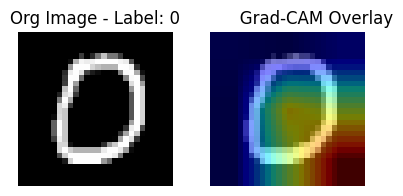

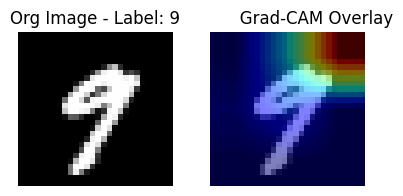

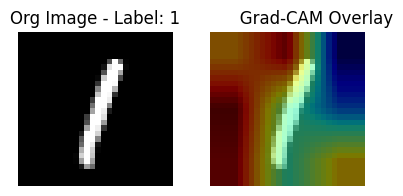

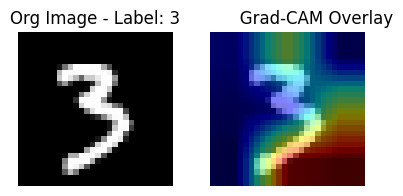

In [ ]:
ro = 0
# Visualize Grad-CAM
image_index = [10,20,5,30]
for i in image_index:
  image = X_test[i]
  label = y_test[i]
  ro+=1
  heatmap = compute_gradcam(model, image, label)
# Resize heatmap to match input image
  heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [28, 28]).numpy().squeeze()
  plt.figure(figsize=(4, 2))
  plt.subplot(1, 2, 1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(f"Org Image - Label: {label}")
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
  plt.title("           Grad-CAM Overlay")
  plt.axis('off')
  plt.tight_layout()
  plt.show()